In [1]:
import numpy as np
import cv2
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
import sys
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm as svm_sk
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import time

# Preprocessing Training data
fruit_images_t = []
labels_t = []
imagesize = 45
for fruit_dir_path in glob.glob("fruits-360/Training/*"):
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        image = cv2.resize(image, (imagesize, imagesize))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        fruit_images_t.append(image)
        labels_t.append(fruit_label)
fruit_images_t = np.array(fruit_images_t)
labels_t = np.array(labels_t)

# Preprocessing Validation data
fruit_images_v = []
labels_v = []
for fruit_dir_path in glob.glob("fruits-360/Validation/*"):
    fruit_label = fruit_dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        image = cv2.resize(image, (imagesize, imagesize))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        fruit_images_v.append(image)
        labels_v.append(fruit_label)
fruit_images_v = np.array(fruit_images_v)
labels_v = np.array(labels_v)

# Create dicts/arrays for Training Data
names_t = np.unique(labels_t)
ids_t = [k for k in range(0, len(names_t))]
name_id_t = list(zip(names_t, ids_t))
id_to_name_t = {id: name for (name, id) in name_id_t}
name_to_id_t = {name: id for (name, id) in name_id_t}
label_ids_t = np.array([name_to_id_t[x] for x in labels_t])

# Create dicts/arrays for Validation data
names_v = np.unique(labels_v)
ids_v = [k for k in range(len(names_v))]
id_name_v = list(zip(ids_v, names_v))
name_to_id_v = {name: id for (id, name) in id_name_v}
id_to_name_v = {id: name for (id, name) in id_name_v}
label_ids_v = np.array([name_to_id_v[x] for x in labels_v])

#End of preprocessing stage

In [5]:
# Test number of PCA components... 
# Scale Training data and then run PCA on it
scaler = StandardScaler()
scaled_images = scaler.fit_transform([im.flatten() for im in fruit_images_t])
images_scaled = scaler.transform([im.flatten() for im in fruit_images_v])
pca = PCA(n_components=24)
pca_result_t = pca.fit_transform(scaled_images)
pca_result_v = pca.transform(images_scaled)   
# Split training set
X_train, X_test, y_train, y_test = train_test_split(pca_result_t, label_ids_t, test_size=0)
# Train svm
svm = svm_sk.SVC(C=1.0, kernel='poly', degree=1)
svm = svm.fit(X_train, y_train)
# Predict on with all classifiers Validation data
svm_prediction_v = svm.predict(pca_result_v)
# Compute accuracy scores for all classifiers
svm_precision_v = accuracy_score(svm_prediction_v, label_ids_v)
acc = svm_precision_v
print(acc)


0.967745270340122


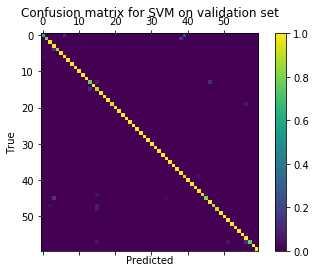

In [7]:
cm_svm_v = confusion_matrix(label_ids_v, svm_prediction_v)
cm_svm_v = normalize(cm_svm_v, axis=1, norm='l1')
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm_svm_v)
plt.title('Confusion matrix for SVM on validation set')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()